# PT Profiles

In this notebook, we list the new PT profiles added in POSEIDON V.1.2. 

Briefly, we have added, 

1. Guillot 
- From Guillot (2010), Equation 29 (https://arxiv.org/pdf/1006.4702)
- Two versions: Guillot (redistribution factor f = 0.25 for terminators or directly imaged exoplanets) and Dayside Guillot (f = 0.5 for hot Jupiter daysides)
2. Line
- From Line et al (2013), Equation 13 (https://arxiv.org/pdf/1304.5561)
3. Pelletier
- From Pelletier et al (2021), (Section 3.5) (https://arxiv.org/pdf/2105.10513)
- Uses 'knots' to fit the PT profile with a second derivative penalty. Used for retrievals. 
4. Slope
- From Piette & Madhusudhan (2021) (https://arxiv.org/pdf/2007.15004)

If you use any of the following profiles, please cite the pertinent work above as well as Mullens et al 2024 to indicate POSEIDON V1.2.

We use HD 189733b to showcase how to define the new PT profiles

In [1]:
from POSEIDON.constants import R_Sun, R_J, M_J
from POSEIDON.core import create_star, create_planet, load_data, define_model, \
                          wl_grid_constant_R, set_priors, read_opacities
from POSEIDON.visuals import plot_data, plot_spectra_retrieved, plot_PT_retrieved
from POSEIDON.retrieval import run_retrieval
from POSEIDON.utility import read_retrieved_spectrum, read_retrieved_PT, \
                             read_retrieved_log_X, plot_collection
from POSEIDON.corner import generate_cornerplot

import numpy as np
from scipy.constants import au
from scipy.constants import parsec as pc

do_retrieval = True

#***** Model wavelength grid *****#

wl_min = 0.2     # Minimum wavelength (um)
wl_max = 30     # Maximum wavelength (um)
R = 5000         # Spectral resolution of grid

# We need to provide a model wavelength grid to initialise instrument properties
wl_1 = np.linspace(wl_min, 1.0, 1000)[:-1]
wl_2 = wl_grid_constant_R(1.0, wl_max, R)
wl_2 = wl_2[1:]    # Indexing to avoid 1.0 um being repeated twice
wl = np.concatenate((wl_1, wl_2))

#***** Define planet properties *****#

planet_name = 'HD 189733b'  # Planet name used for plots, output files etc.

R_p = 1.13*R_J    # Planetary radius (m)
M_p = 1.129*M_J
d = 19.7638*pc
a_p = 0.03142*au

planet = create_planet(planet_name, R_p, mass = M_p, a_p = a_p)


#***** Define stellar properties *****#

R_s = 0.78*R_Sun      # Stellar radius (m)
T_s = 5014         # Stellar effective temperature (K)
Met_s = 0.13          # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)] <--- note: for PHOENIX, only the solar metallicity models are used  
log_g_s = 4.58       # Stellar log surface gravity (log10(cm/s^2) by convention)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s, wl = wl, stellar_grid = 'phoenix')


/Users/elijahmullens/Desktop/POSEIDON-V1-1/POSEIDON/absorption.py:1493: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def store_Rayleigh_eta_LBL(wl_model, chemical_species):


# Dayside Guillot

This profile has four free parameters:

log_kappa_IR = The 'infrared' opacity 


log_gamma = ratio between optical and IR opacity


T_int = Internal temperature


T_equ = 'Equilibrium' temperature 

where the free parameters are used to compute 

$T_{irr} = \sqrt{2}T_{eq}$, and the `infrared optical depth', $\tau = P \kappa_{IR}/g$

which are plugged into

$T^4 = \frac{3T_{int}^4}{4} \left(\frac{2}{3} + \tau\right) \notag \hspace{2pt} + f\frac{3T_{irr}^4}{4}\left(\frac{2}{3} + \frac{1}{\gamma\sqrt{3}} + \left(\frac{\gamma}{\sqrt{3}}-\frac{1}{\gamma\sqrt{3}}\right)e^{-\gamma\tau\sqrt{3}}\right)$

In [3]:
# Guillot Dayside 

model_name_Guillot_dayside = 'Guillot_dayside'

bulk_species = ['H2', 'He']
param_species = []

# Create the model object
model_Guillot_dayside = define_model(model_name_Guillot_dayside, bulk_species, param_species, 
                     PT_profile = 'Guillot_dayside')

print(model_Guillot_dayside['PT_param_names'])

['log_kappa_IR' 'log_gamma' 'T_int' 'T_equ']


Lets set up some parameters and an atmosphere object

In [11]:
from POSEIDON.core import make_atmosphere

# Atmospheric pressure grid
P_min = 1.0e-6   # 10 nbar
P_max = 100       # 10 bar
N_layers = 100   # 100 layers

# Let's space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure
P_ref = 1   # Retrieved R_p_ref parameter will be the radius at 10 bar

# Free parameters
R_p_ref               =   1.12 * R_J

log_kappa_IR =   -4.83 
log_gamma    =   -0.41 
T_int        =   262.8
T_equ        =   1158.0 

PT_params = np.array([log_kappa_IR, log_gamma, T_int, T_equ])
log_X_params = np.array([])
cloud_params = np.array([])

atmosphere_Guillot_dayside = make_atmosphere(planet, model_Guillot_dayside, P, P_ref, R_p_ref, 
                                            PT_params, log_X_params, cloud_params)

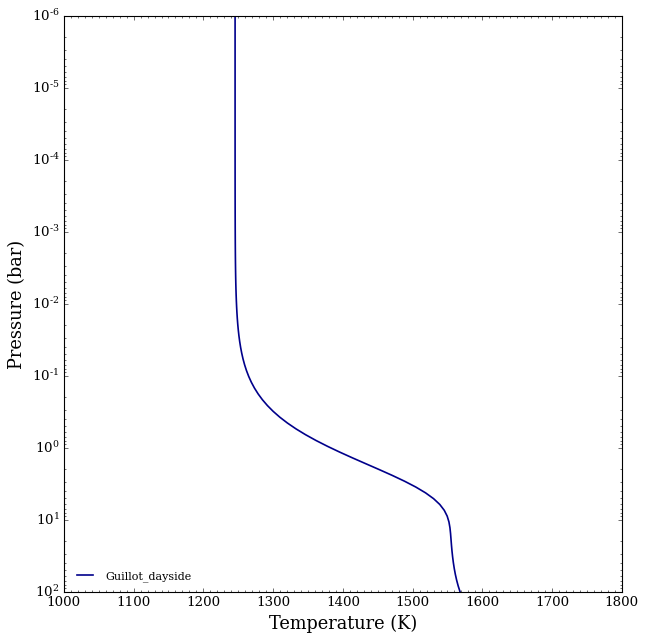

In [12]:
from POSEIDON.visuals import plot_PT, plot_chem

# Produce plots of atmospheric properties
fig_PT = plot_PT(planet, model_Guillot_dayside, atmosphere_Guillot_dayside, log_P_max = 2.0)

Lets see what varying different variables does

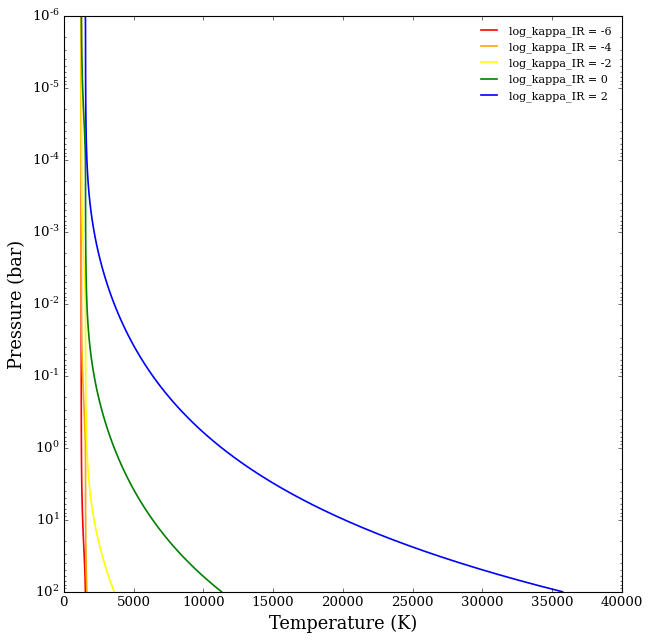

In [13]:
from POSEIDON.visuals import vary_one_parameter_PT

param_name = 'log_kappa_IR'
vary_list = [-6,-4,-2,0,2]

vary_one_parameter_PT(model_Guillot_dayside, planet, param_name, vary_list,
                       P, P_ref, R_p_ref,
                       PT_params, log_X_params, cloud_params,
                       )

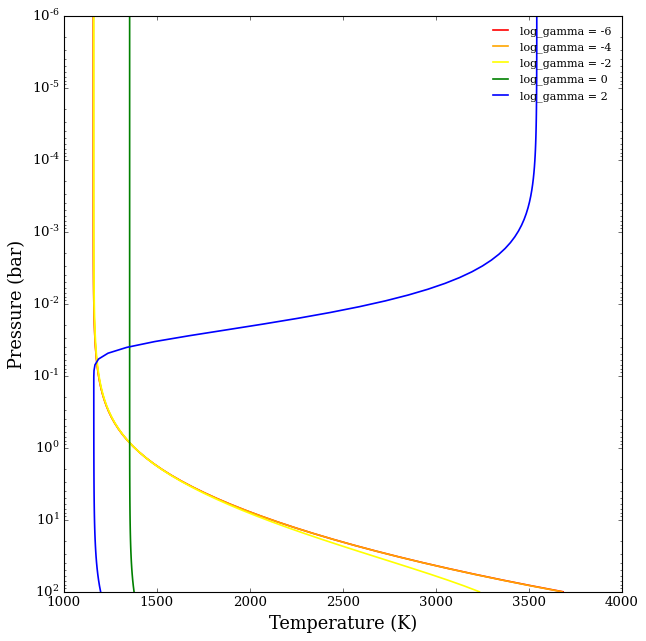

In [14]:
from POSEIDON.visuals import vary_one_parameter_PT

param_name = 'log_gamma'
vary_list = [-6,-4,-2,0,2]

vary_one_parameter_PT(model_Guillot_dayside, planet, param_name, vary_list,
                       P, P_ref, R_p_ref,
                       PT_params, log_X_params, cloud_params,
                       )

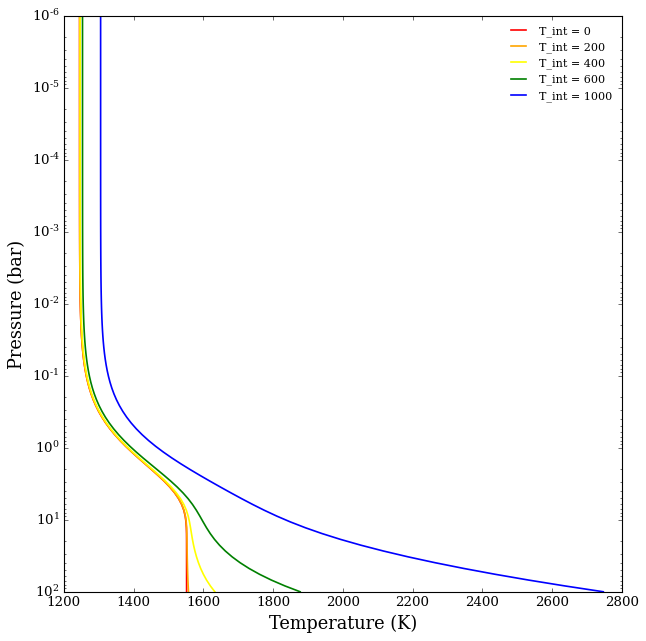

In [15]:
from POSEIDON.visuals import vary_one_parameter_PT

param_name = 'T_int'
vary_list = [0,200,400,600,1000]

vary_one_parameter_PT(model_Guillot_dayside, planet, param_name, vary_list,
                       P, P_ref, R_p_ref,
                       PT_params, log_X_params, cloud_params,
                       )

For normal profiles, T_equ is typically what the upper profile becomes isothermal at.

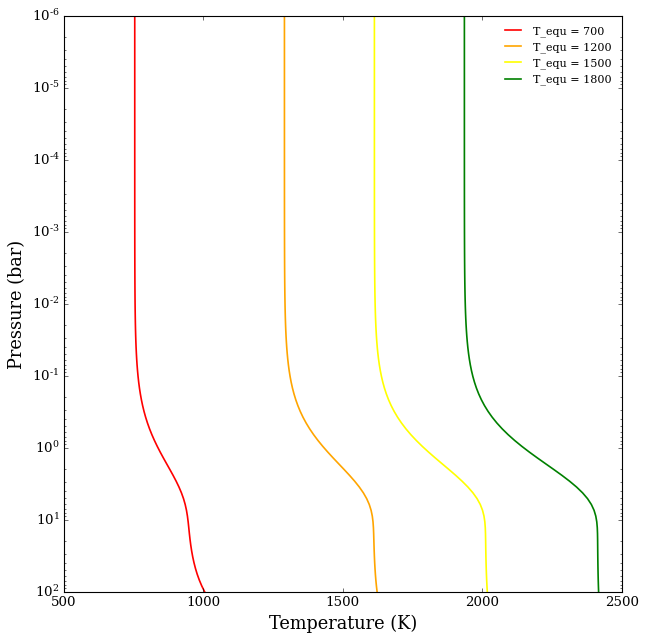

In [16]:
from POSEIDON.visuals import vary_one_parameter_PT

param_name = 'T_equ'
vary_list = [700,1200,1500,1800]

vary_one_parameter_PT(model_Guillot_dayside, planet, param_name, vary_list,
                       P, P_ref, R_p_ref,
                       PT_params, log_X_params, cloud_params,
                       )

# Line

This profile has six free parameters:

log_kappa_IR = The 'infrared' opacity 

log_gamma = ratio between optical and IR opacity (channel 1)

log_gamma_2 = ratio between optical and IR opacity (channel 2)

alpha = partitions the flux between channel 1 and 2 (ranges 0 to 1)

beta = a `catch-all' term for heat redistribution, geometric arguments, emissivity, albedo, and errors in the equilibrium temperature

T_int = Internal temperature

where the free parameters are used to compute 

$T_{irr} = \beta T_{eq}$, and the `infrared optical depth', $\tau = P \kappa_{IR}/g$

which are plugged into

$
T^4 = \frac{3T_{int}^4}{4}\left(\frac{2}{3} + \tau\right) + \frac{3T_{irr}^4}{4}\left(1-\alpha\right)\xi_{\gamma}(\tau) + \frac{3T_{irr}^4}{4}\alpha\xi_{\gamma2}(\tau)
$

where $\xi$ is given by equation 14 in Line 2013.

Note that, unlike the Guillot profile, T_eq is NOT a free parameter and MUST be passed into the planet object. Additionally, the Line profile reduces down to the Guillot profile when alpha = 1. 

In [19]:
planet_name = 'HD 189733b'  # Planet name used for plots, output files etc.

R_p = 1.13*R_J    # Planetary radius (m)
M_p = 1.129*M_J
d = 19.7638*pc
a_p = 0.03142*au

T_eq = 1200

planet = create_planet(planet_name, R_p, mass = M_p, a_p = a_p, T_eq = T_eq)

In [20]:
model_name_Line = 'Line'

#***** Define model *****#

bulk_species = ['H2', 'He']
param_species = []

# Create the model object
model_Line = define_model(model_name_Line, bulk_species, param_species, 
                     PT_profile = 'Line')

print(model_Line['PT_param_names'])

['log_kappa_IR' 'log_gamma' 'log_gamma_2' 'alpha' 'beta' 'T_int']


In [21]:
from POSEIDON.core import make_atmosphere

# Atmospheric pressure grid
P_min = 1.0e-6   # 10 nbar
P_max = 100       # 10 bar
N_layers = 100   # 100 layers

# Let's space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure
P_ref = 1   # Retrieved R_p_ref parameter will be the radius at 10 bar

# Free parameters
R_p_ref               =   1.12 * R_J

log_kappa_IR =   -4.69 
log_gamma    =   -0.31 
log_gamma_2  =   -1.37 
alpha        =   0.11 
beta         =   1.13 
T_int        =   258.8 

PT_params = np.array([log_kappa_IR, log_gamma, log_gamma_2, alpha, beta, T_int])
log_X_params = np.array([])
cloud_params = np.array([])

atmosphere_Line = make_atmosphere(planet, model_Line, P, P_ref, R_p_ref, 
                                            PT_params, log_X_params, cloud_params)

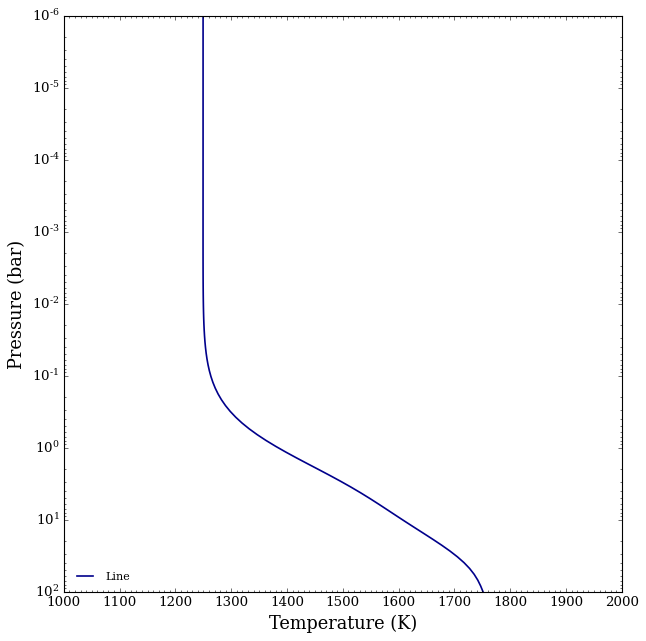

In [23]:
from POSEIDON.visuals import plot_PT, plot_chem

# Produce plots of atmospheric properties
fig_PT = plot_PT(planet, model_Line, atmosphere_Line, log_P_max = 2.0)

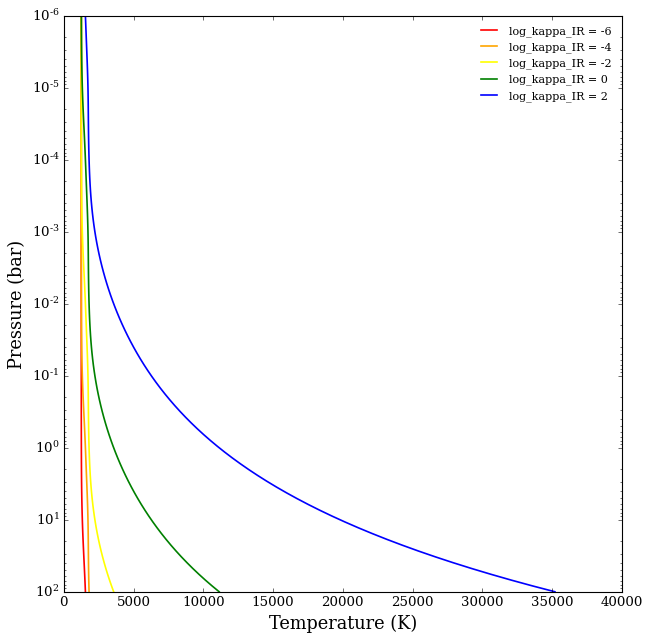

In [24]:
from POSEIDON.visuals import vary_one_parameter_PT

param_name = 'log_kappa_IR'
vary_list = [-6,-4,-2,0,2]

vary_one_parameter_PT(model_Line, planet, param_name, vary_list,
                       P, P_ref, R_p_ref,
                       PT_params, log_X_params, cloud_params,
                       )

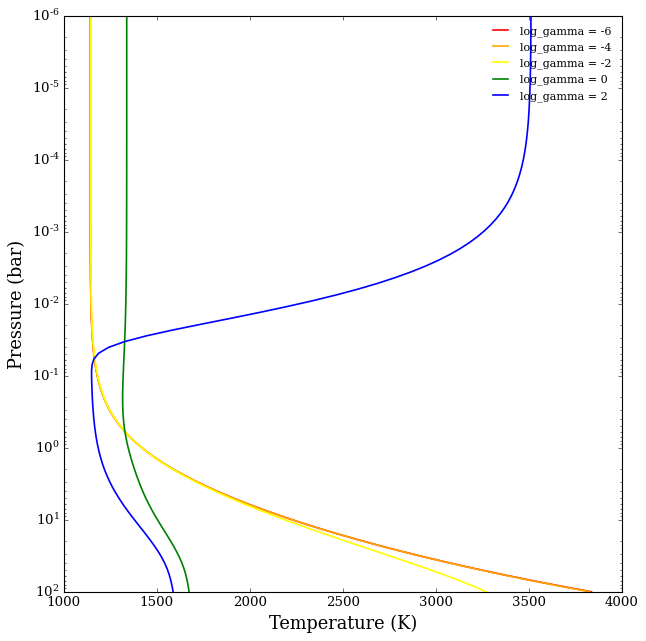

In [25]:
from POSEIDON.visuals import vary_one_parameter_PT

param_name = 'log_gamma'
vary_list = [-6,-4,-2,0,2]

vary_one_parameter_PT(model_Line, planet, param_name, vary_list,
                       P, P_ref, R_p_ref,
                       PT_params, log_X_params, cloud_params,
                       )

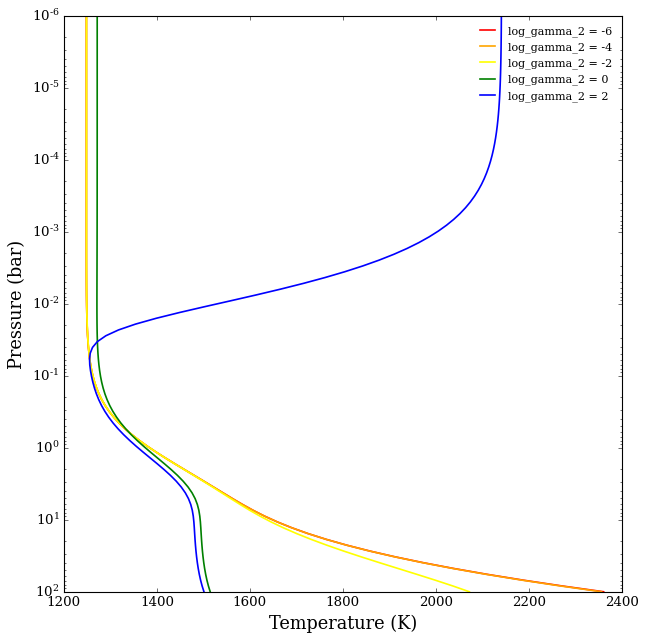

In [26]:
from POSEIDON.visuals import vary_one_parameter_PT

param_name = 'log_gamma_2'
vary_list = [-6,-4,-2,0,2]

vary_one_parameter_PT(model_Line, planet, param_name, vary_list,
                       P, P_ref, R_p_ref,
                       PT_params, log_X_params, cloud_params,
                       )

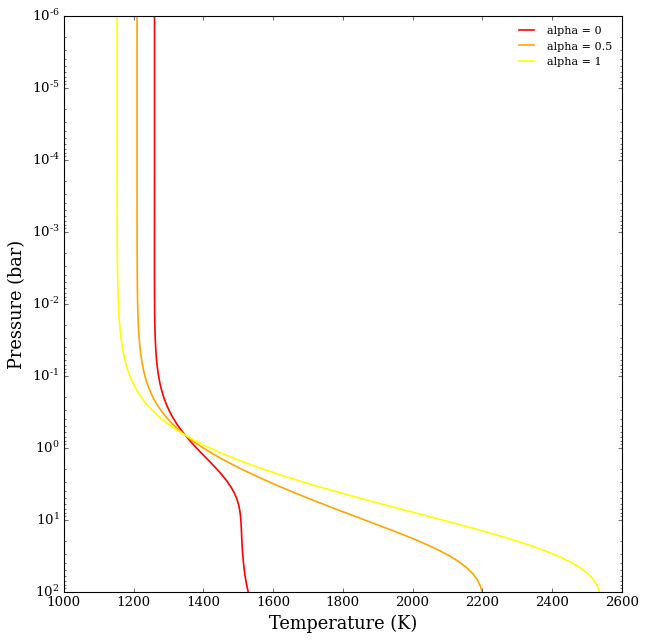

In [27]:
from POSEIDON.visuals import vary_one_parameter_PT

param_name = 'alpha'
vary_list = [0,0.5,1]

vary_one_parameter_PT(model_Line, planet, param_name, vary_list,
                       P, P_ref, R_p_ref,
                       PT_params, log_X_params, cloud_params,
                       )

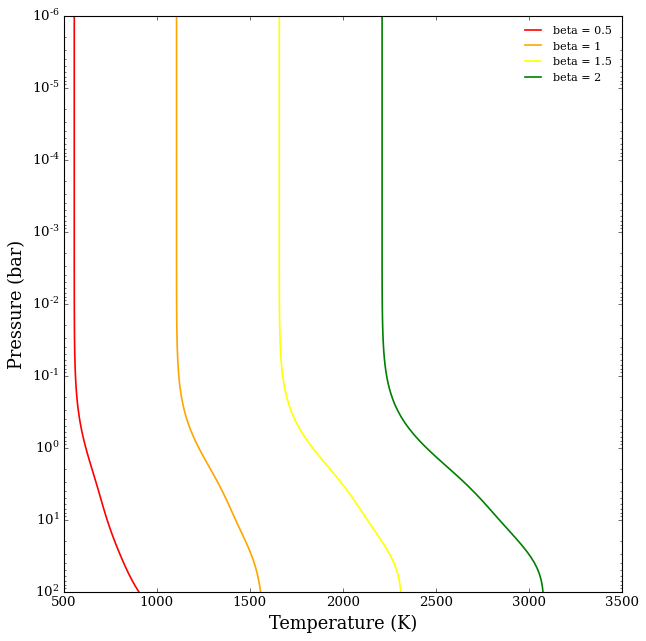

In [28]:
from POSEIDON.visuals import vary_one_parameter_PT

param_name = 'beta'
vary_list = [0.5,1,1.5,2]

vary_one_parameter_PT(model_Line, planet, param_name, vary_list,
                       P, P_ref, R_p_ref,
                       PT_params, log_X_params, cloud_params,
                       )

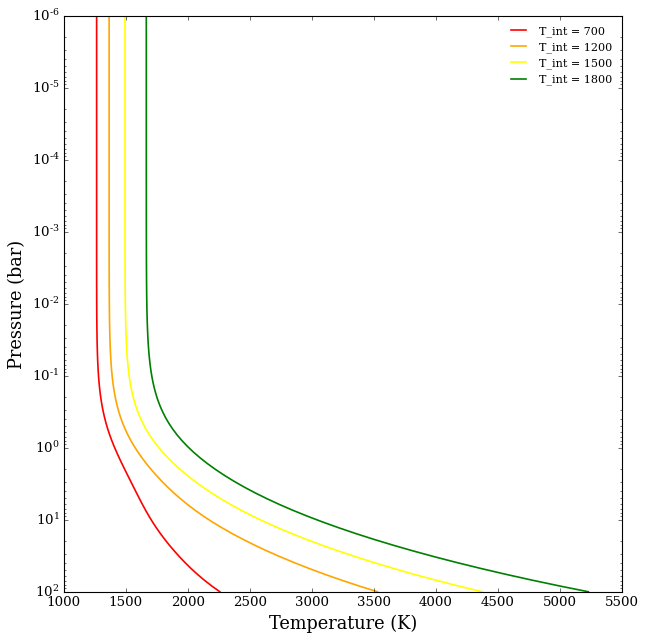

In [29]:
from POSEIDON.visuals import vary_one_parameter_PT

param_name = 'T_int'
vary_list = [700,1200,1500,1800]

vary_one_parameter_PT(model_Line, planet, param_name, vary_list,
                       P, P_ref, R_p_ref,
                       PT_params, log_X_params, cloud_params,
                       )

# Pelletier 

This profile has no set number of parameters. 

It generated a uniform number of knots in between P_min and P_max.

Below, I have 9 knots, which will set the knots to be at each pressure level (2,1,0,-1,-2,-3,-4,-5,-6) bars.

T_1 represents the top of the atmosphere (1e-6 bars) and T_9 represents the bottom (1e2 bars)

Additionally, this model is primarily used in retrievals where it has a second derivative penalty on the PT profile (to prevent it from getting too wriggly)

This parameter is called sigma_s and is fit for during a retrieval. We reccomend setting a pretty tight prior on this parameter.

(For example, for 150 is a strict second derivative prior while 550 is not. The priors I set were +/- 20 that value.)

In [10]:
model_name_Pelletier = 'Pelletier'

bulk_species = ['H2', 'He']
param_species = []

# Create the model object
model_Pelletier = define_model(model_name_Pelletier, bulk_species, param_species, 
                     PT_profile = 'Pelletier',
                     number_P_knots = 9, PT_penalty = True)

print(model_Pelletier['PT_param_names'])

['T_1' 'T_2' 'T_3' 'T_4' 'T_5' 'T_6' 'T_7' 'T_8' 'T_9' 'sigma_s']


Results from sigma_s = 150

In [11]:
from POSEIDON.core import make_atmosphere

# Atmospheric pressure grid
P_min = 1.0e-6   # 10 nbar
P_max = 100       # 10 bar
N_layers = 100   # 100 layers

# Let's space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure
P_ref = 1   # Retrieved R_p_ref parameter will be the radius at 10 bar

# Free parameters
R_p_ref               =   1.12 * R_J

T_1     =   1222.7 
T_2     =   1176.1
T_3     =   1172.5
T_4     =   1162.1
T_5     =   1179.5
T_6     =   1258.0
T_7     =   1368.8
T_8     =   1564.1
T_9     =   1775.1 
sigma_s =   155.54 

PT_params = np.array([T_1,T_2,T_3,T_4,T_5,T_6,T_7,T_8,T_9,sigma_s])
log_X_params = np.array([])
cloud_params = np.array([])

atmosphere_Pelletier = make_atmosphere(planet, model_Pelletier, P, P_ref, R_p_ref, 
                                            PT_params, log_X_params, cloud_params)

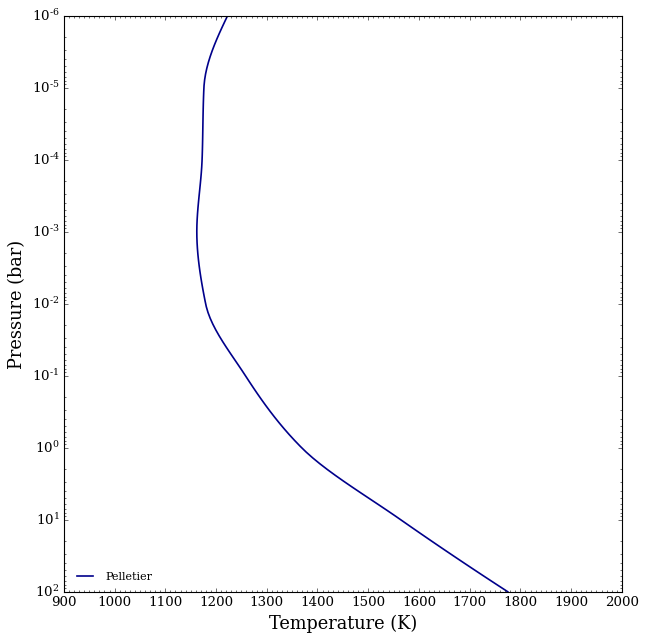

In [12]:
from POSEIDON.visuals import plot_PT, plot_chem

# Produce plots of atmospheric properties
fig_PT = plot_PT(planet, model_Pelletier, atmosphere_Pelletier, log_P_max = 2.0)

Now from the more 'relaxed' sigma_s = 550

In [13]:
from POSEIDON.core import make_atmosphere

# Atmospheric pressure grid
P_min = 1.0e-6   # 10 nbar
P_max = 100       # 10 bar
N_layers = 100   # 100 layers

# Let's space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure
P_ref = 1   # Retrieved R_p_ref parameter will be the radius at 10 bar

# Free parameters
R_p_ref               =   1.12 * R_J

T_1     =   835.0 
T_2     =   732.9 
T_3     =   982.5  
T_4     =   1631.1
T_5     =   540.1  
T_6     =   1378.0 
T_7     =   2213.9 
T_8     =   1957.9 
T_9     =   1624.7 
sigma_s =   552.50 

PT_params = np.array([T_1,T_2,T_3,T_4,T_5,T_6,T_7,T_8,T_9,sigma_s])
log_X_params = np.array([])
cloud_params = np.array([])

atmosphere_Pelletier = make_atmosphere(planet, model_Pelletier, P, P_ref, R_p_ref, 
                                            PT_params, log_X_params, cloud_params)

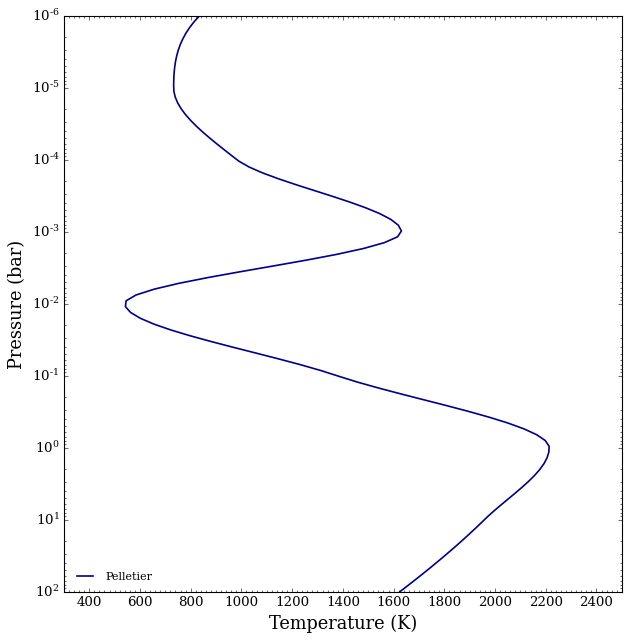

In [14]:
from POSEIDON.visuals import plot_PT, plot_chem

# Produce plots of atmospheric properties
fig_PT = plot_PT(planet, model_Pelletier, atmosphere_Pelletier, log_P_max = 2.0)

Its a lot more wriggly! Like we would expect

# Slope 

This profile has as many free parameters as the user specifies.

The original P-T profile, as defined in Piette & Madhusudhan (2021), fits for a photospheric temperature at 3.16 bars and a fixed number of $\Delta$ T parameters between specific pressure anchor points (e.g., $\Delta T$ from 10 to 1\,mbar). 

The implementation here allows the user to define the pressure of the photosphere and the pressure edges where the $\Delta T$ parameters are defined (i.e., the number of $\Delta T$ parameters is a user choice). This parameterization is much better suited than other P-T profiles at fitting a deep temperature adiabat with a decreasing temperature with height. 

The slope profile explicitly assumes monotonically decreasing temperature with altitude and thus does not allow for thermal inversions (i.e., the $\Delta T > 0$).

Below: The photosphere is defined at 1e-1 bars with $\Delta$ T$_1$ from 1e-6 to 1e-5 bars, $\Delta$ T$_2$ from 1e-5 to 1e-4 bars, and so forth. T_phot acts as the anchor point.

In [15]:
model_name_slope = 'Slope'

#***** Define model *****#

bulk_species = ['H2', 'He']
param_species = []

# Create the model object
model_slope = define_model(model_name_slope, bulk_species, param_species, 
                     PT_profile = 'slope',
                     log_P_slope_phot = -1,
                     log_P_slope_arr = [-6.0, -5.0, -4.0, -3.0, -2.0, 0.0, 1.0, 2.0,])

In [17]:
from POSEIDON.core import make_atmosphere

# Atmospheric pressure grid
P_min = 1.0e-6   # 10 nbar
P_max = 100       # 10 bar
N_layers = 100   # 100 layers

# Let's space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure
P_ref = 1   # Retrieved R_p_ref parameter will be the radius at 10 bar

# Free parameters
R_p_ref               =   1.12 * R_J

T_phot_PT =   1281.8 
Delta_T_1 =   228.4 
Delta_T_2 =   189.0 
Delta_T_3 =   190.0 
Delta_T_4 =   137.9 
Delta_T_5 =   67.2 
Delta_T_6 =   81.7 
Delta_T_7 =   221.3 
Delta_T_8 =   477.7

PT_params = np.array([T_phot_PT, Delta_T_1, Delta_T_2, Delta_T_3, Delta_T_4, Delta_T_5, Delta_T_6, Delta_T_7, Delta_T_8])
log_X_params = np.array([])
cloud_params = np.array([])

atmosphere_slope = make_atmosphere(planet, model_slope, P, P_ref, R_p_ref, 
                                            PT_params, log_X_params, cloud_params)

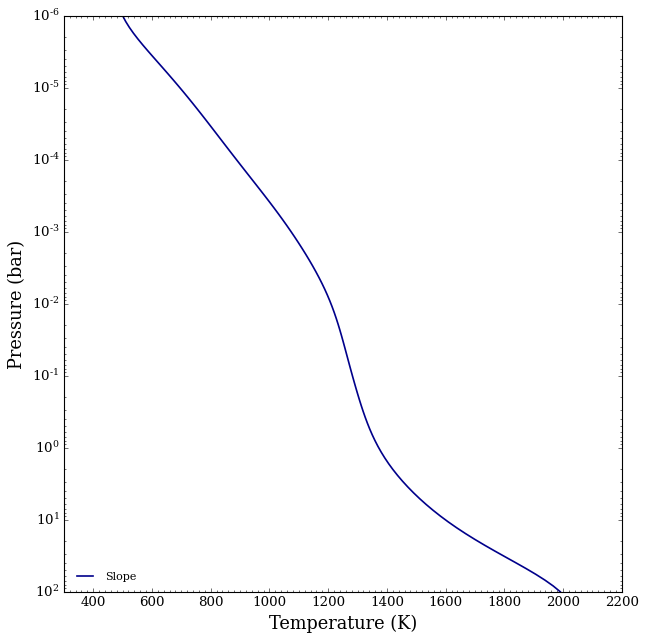

In [19]:
from POSEIDON.visuals import plot_PT, plot_chem

# Produce plots of atmospheric properties
fig_PT = plot_PT(planet, model_slope, atmosphere_slope, log_P_max = 2.0)